# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

if torch.cuda.is_available(): # If there's a GPU available...   
    device = torch.device("cuda") # Tell PyTorch to use the GPU
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
%%capture
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import csv

import time
import datetime
import random

#----------------------------------------------------------#
from transformers import AutoModelForSequenceClassification
#----------------------------------------------------------#

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score # performance metric on test set

In [ ]:
SEED = 2100 # fine-tuning seed

#LEARNING_RATE = 2e-4 # author recommends
#LEARNING_RATE = 1.5e-4
#LEARNING_RATE = 1e-4
LEARNING_RATE = 5e-5
#LEARNING_RATE = 3e-5
#LEARNING_RATE = 2e-5

#EPOCHS = 12
#EPOCHS = 7
#EPOCHS = 6
EPOCHS = 5 # author recommends
#EPOCHS = 3       

In [ ]:
def check_gpu_mem():

    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')
    reader = csv.reader(buf, delimiter=',')
    df = pd.DataFrame(reader)
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    return df

In [ ]:
check_gpu_mem() # memory.used should be 2 MiB

,memory.total [MiB],memory.used [MiB]
1,16280 MiB,2 MiB


In [ ]:
#-----------------------------#
#-----------------------------#
SUBSTANCE_FOLDER = "drug"
SPLITTING_SEED = "2001"
#-----------------------------#
#-----------------------------#

dataloader_folder = f"/content/drive/MyDrive/dataloaders_for_BioELECTRA/{SUBSTANCE_FOLDER}/{SPLITTING_SEED}/"

In [ ]:
# truncation: 35 before, 165 after
# batch size: 32 | token length: 64
name = "train_DL_JA_35b165a_32_64" 
f = open(f"{dataloader_folder}{name}", "rb")
train_dataloader = pickle.load(f)
f.close()
len(train_dataloader)

50

In [ ]:
for batch in train_dataloader:
    print(type(batch))
    print(len(batch))
    print(batch) 
    break

<class 'list'>
3
[tensor([[    2,  3711,  1685,  ...,     0,     0,     0],
        [    2,    64,  1025,  ...,     0,     0,     0],
        [    2,  5304,  5125,  ...,     0,     0,     0],
        ...,
        [    2,  3880,  1677,  ...,     0,     0,     0],
        [    2,  2277,  4810,  ...,     0,     0,     0],
        [    2, 11811, 10902,  ...,     0,     0,     0]], dtype=torch.int32), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]


In [ ]:
name = "valid_DL_JA_35b165a_32_64"
f = open(f"{dataloader_folder}{name}", "rb")
validation_dataloader = pickle.load(f)
f.close()
len(validation_dataloader)

6

In [ ]:
for batch in validation_dataloader:
    print(type(batch))
    print(len(batch))
    print(batch) 
    break 

<class 'list'>
3
[tensor([[    2,  1685, 11359,  ...,     0,     0,     0],
        [    2,    66,  2574,  ...,     0,     0,     0],
        [    2,    60,  8984,  ...,     0,     0,     0],
        ...,
        [    2, 11875,  2428,  ...,     0,     0,     0],
        [    2,    46,  5051,  ...,     0,     0,     0],
        [    2, 13704,  3434,  ...,     0,     0,     0]], dtype=torch.int32), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0])]


# Fine-Tuning

In [ ]:
%%capture 
model = AutoModelForSequenceClassification.from_pretrained(
    "kamalkraj/bioelectra-base-discriminator-pubmed",
    num_labels=2, 
    output_attentions = False, 
    output_hidden_states = False
)
model.cuda()

Some weights of the model checkpoint at kamalkraj/bioelectra-base-discriminator-pubmed were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at kamalkraj/bioelectra-base-discriminator-pubmed and are newly i

In [ ]:
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,16280 MiB,1381 MiB


In [ ]:
optimizer = AdamW(model.parameters(), # 'W' = 'Weight Decay fix"
                  lr = LEARNING_RATE, # defined above       (as in ConvBERT paper)
                  eps = 1e-6 #                              (as in ConvBERT paper)
                  # betas (b1, b2) default to 0.9 and 0.999 (as in ConvBERT paper)
                  # weight_decay defaults to 0              (as in ConvBERT paper)
                )

In [ ]:
epochs = EPOCHS 

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
total_steps # if we were using a batch size of 16, we would perform twice as many steps

250

**Training Loop**

In each pass, we will train the model on our full training set, and then measure it's accuracy on our 10% holdout validation set.

Let's define a few helper functions:

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training code based on the `run_glue.py` [script](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128)

In [ ]:
seed_val = SEED # Set the seed value all over the place to make this reproducible.

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs): # For each epoch...
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time() # Measure how long the training epoch takes.

    total_loss = 0 # Reset the total loss for this epoch.

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it DOESN'T LITERALLY *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    for step, batch in enumerate(train_dataloader): # For each batch of training data...

        if step % 25 == 0 and not step == 0: # Progress update every 25 batches.
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!") 


======== Epoch 1 / 5 ========
Training...
  Batch    25  of     50.    Elapsed: 0:00:05.

  Average training loss: 0.17
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.98
  Validation took: 0:00:00

======== Epoch 2 / 5 ========
Training...
  Batch    25  of     50.    Elapsed: 0:00:05.

  Average training loss: 0.08
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:00

======== Epoch 3 / 5 ========
Training...
  Batch    25  of     50.    Elapsed: 0:00:05.

  Average training loss: 0.03
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:00

======== Epoch 4 / 5 ========
Training...
  Batch    25  of     50.    Elapsed: 0:00:05.

  Average training loss: 0.01
  Training epcoh took: 0:00:10

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:00

======== Epoch 5 / 5 ========
Training...
  Batch    25  of     50.    Elapsed: 0:00:05.

  Average training loss: 0.01
  T

Let's take a look at our training loss over all batches:

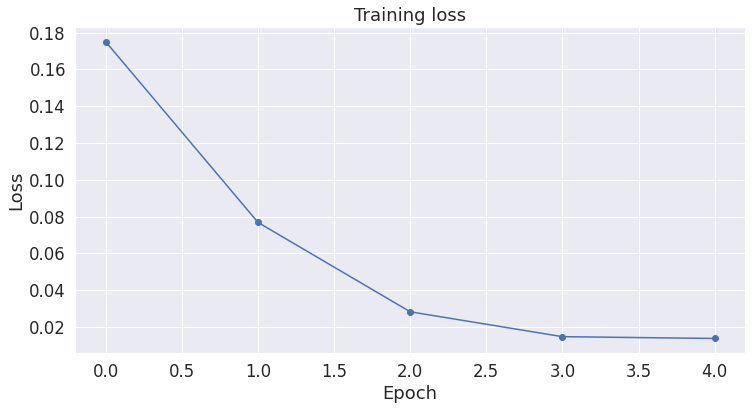

In [ ]:
% matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o') # Plot the learning curve.

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Evaluation
Now we'll load the holdout (test) set, prepared and formatted in the exact same manner as the training data.

In [ ]:
name = "test_DL_JA_35b165a_32_64"
f = open(f"{dataloader_folder}{name}", "rb")
test_dataloader = pickle.load(f)
f.close()
len(test_dataloader) # number of batches in dataloader

14

In [ ]:
for batch in test_dataloader:
    print(type(batch))
    print(len(batch))
    print(batch) 
    break

<class 'list'>
3
[tensor([[    2, 11811, 10902,  ...,     0,     0,     0],
        [    2, 15006,  1033,  ...,     0,     0,     0],
        [    2,  3135,  2921,  ...,     0,     0,     0],
        ...,
        [    2,  5065,  6905,  ...,     0,     0,     0],
        [    2,  1833,  2748,  ...,     0,     0,     0],
        [    2, 12002,  1689,  ...,     0,     0,     0]], dtype=torch.int32), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]


With the test set prepared, we can apply our fine-tuned model to generate predictions on this test set.

In [ ]:
print('Predicting labels for test sentences...') # Prediction on test set

model.eval() # Put model in evaluation mode
predictions , true_labels = [], [] # Tracking variables 
t0 = time.time() # Measure elapsed time.

for (step, batch) in enumerate(test_dataloader): # Predict

    batch = tuple(t.to(device) for t in batch) # Add batch to GPU
  
    if step % 25 == 0 and not step == 0: # Progress update every 25 batches.

        elapsed = format_time(time.time() - t0) # Calculate elapsed time in minutes.
        
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


    b_input_ids, b_input_mask, b_labels = batch # Unpack the inputs from our dataloader
  
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for test sentences...
    DONE.


In [ ]:
# RUN CELL ONCE
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
predictions.shape, true_labels.shape

((444, 2), (444,))

In [ ]:
predictions[0:10], true_labels[0:10]

(array([[ 3.4228864, -3.072373 ],
        [ 3.4221053, -3.0844035],
        [ 3.3936248, -3.0767388],
        [ 3.378662 , -3.032909 ],
        [ 3.394611 , -3.0609708],
        [ 3.4006248, -3.068523 ],
        [ 3.3927033, -3.0677042],
        [ 3.4187717, -3.090024 ],
        [ 3.4159813, -3.0846734],
        [ 3.405515 , -3.0692437]], dtype=float32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
classes = []
for pred in predictions[:,1]:
    if pred > 0:
        classes.append(1)
    if pred < 0:
        classes.append(0)

true_labels = list(true_labels)
print("PREDICTED positive labels:", classes.count(1))
print("ACTUAL positive labels:", true_labels.count(1))

PREDICTED positive labels: 7
ACTUAL positive labels: 8


In particular, our dataset lacked positive drug samples.

In [ ]:
from sklearn.metrics import roc_auc_score # Our performance metric for the test set.

p1 = predictions[:,1] # Use the model output for label 1 as our predictions.
auc = roc_auc_score(true_labels, p1) # Calculate the ROC AUC.

true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0

for index, value in enumerate(list(true_labels)):
    if (classes[index] == 1) and (true_labels[index] == 1): # true positive
        true_positives+=1 
    if (classes[index] == 1) and (true_labels[index] == 0): # false positive
        false_positives+=1
    if (classes[index] == 0) and (true_labels[index] == 1): # false negative
        false_negatives+=1
    if (classes[index] == 0) and (true_labels[index] == 0): # true negative
        true_negatives+=1
        
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"False Negatives: {false_negatives}")
print(f"True Negatives: {true_negatives}")
print("---------------------")

precision = np.round(true_positives/(true_positives + false_positives), 3)
recall = np.round(true_positives/(true_positives + false_negatives), 3)
f1_score = np.round(2*((precision * recall)/(precision + recall)), 3)

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1_score}")
print("---------------------")
print('Test ROC AUC: %.3f' %auc)
print("---------------------")
print("COPY THE RESULTS BELOW:")
print(np.around(precision*100, 3), np.around(recall*100, 3), np.around(f1_score*100, 3))

True Positives: 7
False Positives: 0
False Negatives: 1
True Negatives: 436
---------------------
Precision = 1.0
Recall = 0.875
F1 Score = 0.933
---------------------
Test ROC AUC: 1.000
---------------------
COPY THE RESULTS BELOW:
100.0 87.5 93.3
